<a href="https://colab.research.google.com/github/Serbeld/covid-chestxray-dataset/blob/master/Covid_19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#!pip install lime

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries
import pandas as pd

plt.rcParams["figure.figsize"] = (20,10)

from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.append('/content/drive/My Drive/covid-chestxray-dataset/')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
## global params
INIT_LR = 1e-4  # learning rate
EPOCHS = 21  # training epochs
BS = 8  # batch size


## load and prepare data
imagePaths = list(paths.list_images("/content/drive/My Drive/covid-chestxray-dataset-master/images/"))
data_from_csv = pd.read_csv("/content/drive/My Drive/covid-chestxray-dataset-master/metadata.csv")
name = data_from_csv['filename'].values
covid = data_from_csv['finding'].values

#print(imagePaths)
data = []
labels = []
# loop over the image paths
for imagePath in imagePaths:

    # extract the class label from the filename
    label = imagePath.split(os.path.sep)[-1]
    # load the image, swap color channels, and resize it to be a fixed
    # 224x224 pixels while ignoring aspect ratio
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))
    # update the data and labels lists, respectively
    
    #Busca la imagen en dataset
    for i in range(len(covid)):
      
      if label == name[i]:
        
        print(label)

        # si es igual a covid etiqueta como 1
        if covid[i] == 'COVID-19':
          data.append(image)
          labels.append(1)
          print("COVID-19")

        # sino es covid entoncs etiqueta como 0
        else:
          data.append(image)
          labels.append(0)
          print("OTHERS")


covid-19-rapidly-progressive-acute-respiratory-distress-syndrome-ards-day-1.jpg
COVID-19
1-s2.0-S0929664620300449-gr2_lrg-b.jpg
COVID-19
D5ACAA93-C779-4E22-ADFA-6A220489F840.jpeg
COVID-19
kjr-21-e24-g003-l-a.jpg
COVID-19
5083A6B7-8983-472E-A427-570A3E03DDEE.jpeg
OTHERS
SARS-10.1148rg.242035193-g04mr34g07b-Fig7b-day12.jpeg
OTHERS
1-s2.0-S1684118220300682-main.pdf-002-a1.png
COVID-19
pneumocystis-jirovecii-pneumonia-3-3.jpg
OTHERS
5A78BCA9-5B7A-440D-8A4E-AE7710EA6EAD.jpeg
COVID-19
jkms-35-e79-g001-l-c.jpg
COVID-19
SARS-10.1148rg.242035193-g04mr34g07a-Fig7a-day5.jpeg
OTHERS
E63574A7-4188-4C8D-8D17-9D67A18A1AFA.jpeg
COVID-19
legionella-pneumonia-1.png
OTHERS
F2DE909F-E19C-4900-92F5-8F435B031AC6.jpeg
COVID-19
1.CXRCTThoraximagesofCOVID-19fromSingapore.pdf-001-fig2a.png
COVID-19
pneumococcal-pneumonia-day0.jpg
OTHERS
1-s2.0-S0929664620300449-gr2_lrg-d.jpg
COVID-19
nejmoa2001191_f3-L.jpeg
COVID-19
FC230FE2-1DDF-40EB-AA0D-21F950933289.jpeg
COVID-19
covid-19-pneumonia-28.png
COVID-19
jkms-35-e7

In [0]:
# convert the data and labels to NumPy arrays while scaling the pixel
# intensities to the range [0, 1]
data = np.array(data) / 255.0
labels = np.array(labels)

TEST_SET_SIZE = 0.2

lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels); 
#print(labels) 
#COVID  [0. 1.]
#OTHERS [1. 0.]

# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels,test_size=TEST_SET_SIZE, stratify=labels, random_state=42)
# initialize the training data augmentation object
trainAug = ImageDataGenerator(rotation_range=15,fill_mode="nearest")


In [5]:
## build network
baseModel = VGG16(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))
# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
    layer.trainable = False

print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
    metrics=["accuracy"])

model.summary()

[INFO] compiling model...
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None,

In [6]:
## train
print("[INFO] training head...")
H = model.fit_generator(
    trainAug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS)


[INFO] training head...
Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/21
22/22 [==============================] - 3s 150ms/step - loss: 0.6668 - accuracy: 0.6307 - val_loss: 0.5992 - val_accuracy: 0.7333
Epoch 2/21
22/22 [==============================] - 2s 106ms/step - loss: 0.6795 - accuracy: 0.6082 - val_loss: 0.5813 - val_accuracy: 0.7333
Epoch 3/21
22/22 [==============================] - 2s 105ms/step - loss: 0.6666 - accuracy: 0.6491 - val_loss: 0.5769 - val_accuracy: 0.7333
Epoch 4/21
22/22 [==============================] - 2s 107ms/step - loss: 0.6617 - accuracy: 0.6491 - val_loss: 0.5736 - val_accuracy: 0.7333
Epoch 5/21
22/22 [==============================] - 2s 103ms/step - loss: 0.6400 - accuracy: 0.6667 - val_loss: 0.5716 - val_accuracy: 0.7333
Epoch 6/21
22/22 [==============================] - 2s 107ms/step - loss: 0.6917 - accuracy: 0.6374 - val_loss: 0.5703 - val_accuracy: 0.7333
Epoch 7/21
22/22 [==============================

In [7]:
print("[INFO] saving COVID-19 detector model...")
model.save("/content/drive/My Drive/covid-chestxray-dataset-master/covid19.model", save_format="h5")

[INFO] saving COVID-19 detector model...


In [8]:
## eval
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)
predIdxs = np.argmax(predIdxs, axis=1) # argmax for the predicted probability
#print(classification_report(testY.argmax(axis=1), predIdxs,target_names=lb.classes_))

cm = confusion_matrix(testY.argmax(axis=1), predIdxs)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
# show the confusion matrix, accuracy, sensitivity, and specificity
print(cm)
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))


[INFO] evaluating network...
[[ 0 12]
 [ 0 33]]
acc: 0.7333
sensitivity: 0.0000
specificity: 1.0000


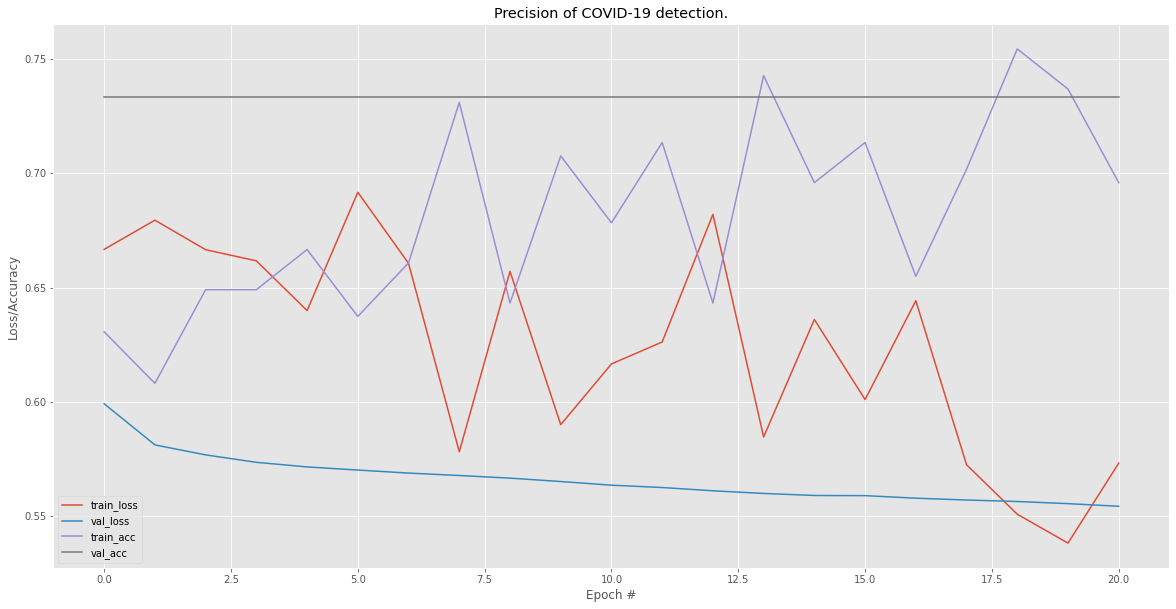

In [9]:
## explain
N = EPOCHS
plt.style.use("ggplot")
plt.figure(1)
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Precision of COVID-19 detection.")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("/content/drive/My Drive/covid-chestxray-dataset-master/training_plot.png")

plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


> label: 1 - predicted: 1


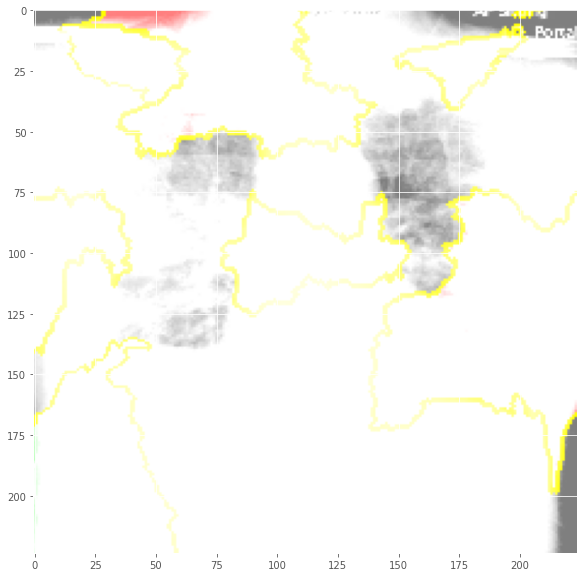


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


> label: 0 - predicted: 1


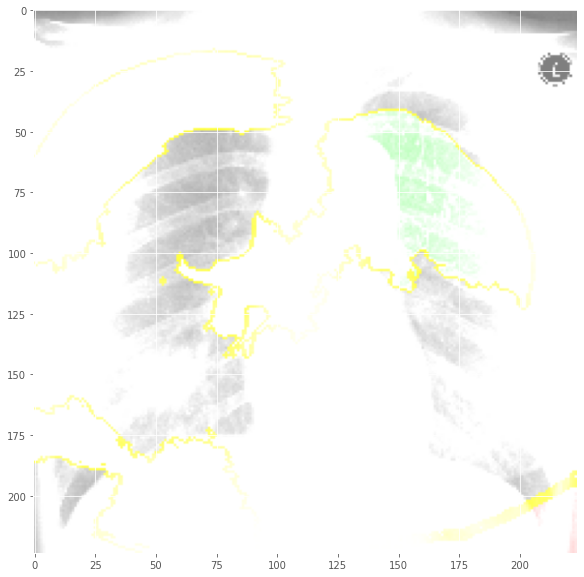


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


> label: 0 - predicted: 1


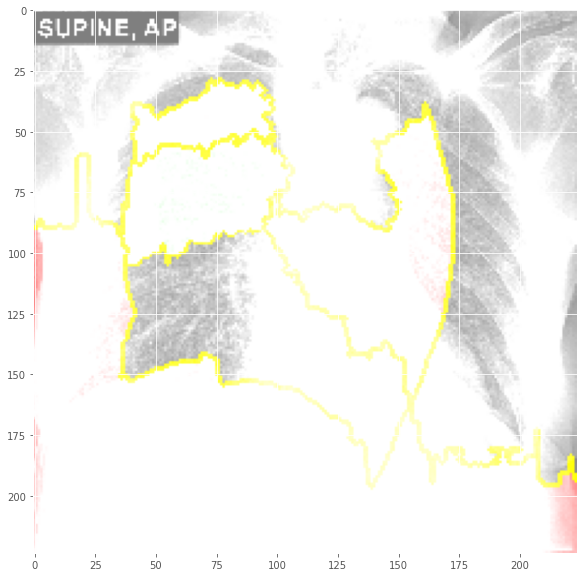


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


> label: 1 - predicted: 1


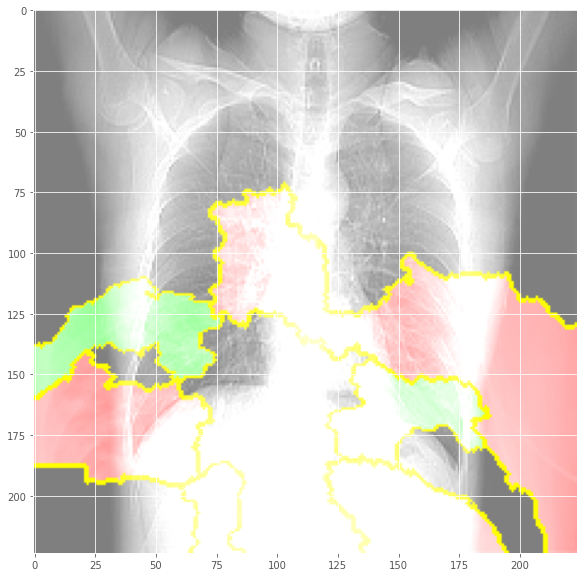


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


> label: 1 - predicted: 1


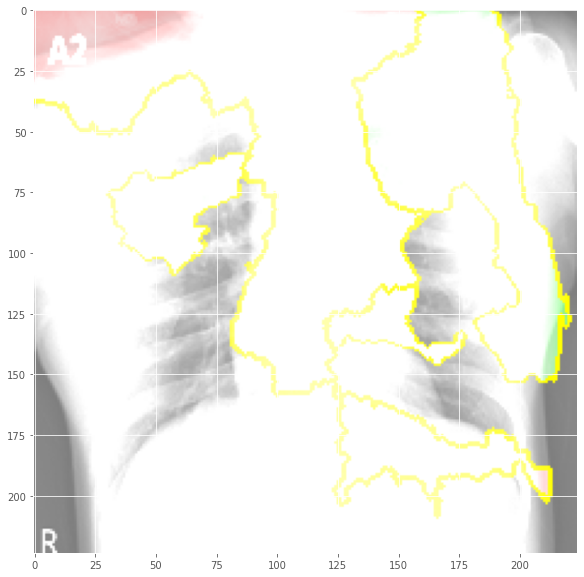


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


> label: 1 - predicted: 1


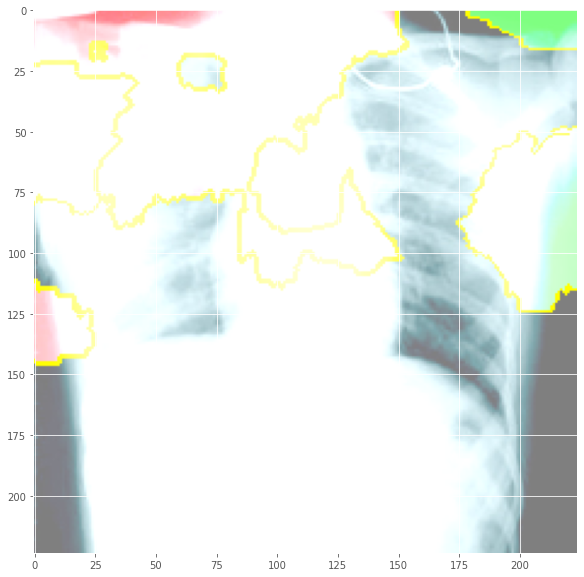


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


> label: 0 - predicted: 1


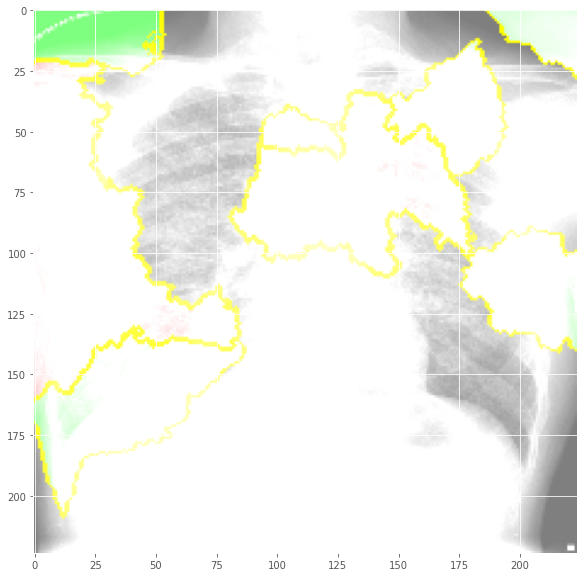


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


> label: 1 - predicted: 1


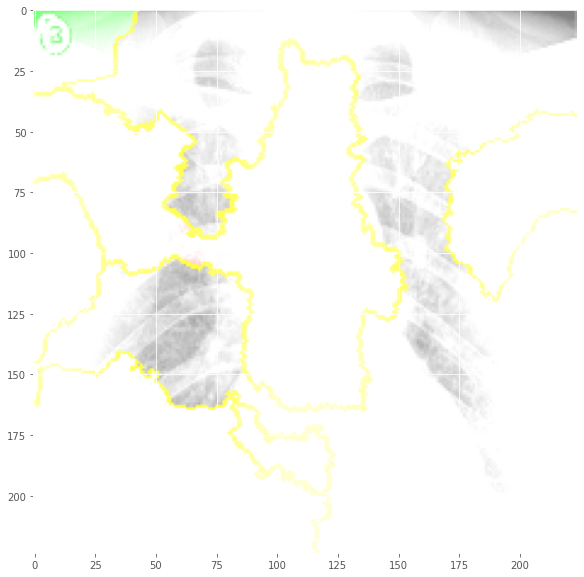


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


> label: 1 - predicted: 1


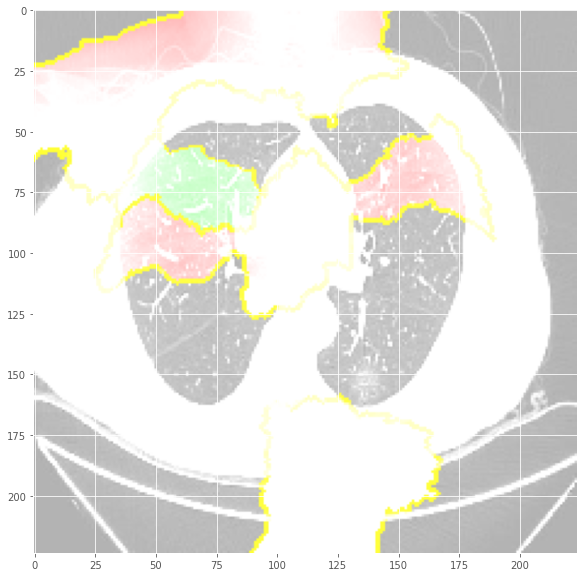


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


> label: 0 - predicted: 1


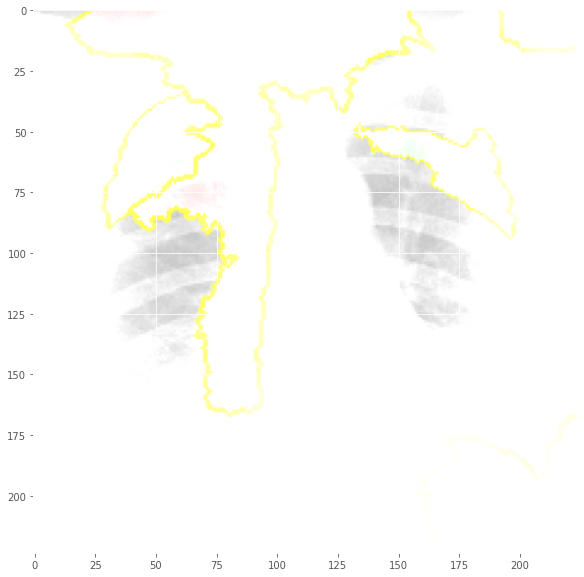

In [10]:
plt.figure(2)
for ind in range(10): 
    explainer = lime_image.LimeImageExplainer()
    explanation = explainer.explain_instance(testX[-ind], model.predict,
                                             hide_color=0, num_samples=42)
    print("> label:", testY[ind].argmax(), "- predicted:", predIdxs[ind])
    
    temp, mask = explanation.get_image_and_mask(
    explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=True)
    plt.imshow(mark_boundaries(temp / 2 + 0.5, mask)+testX[ind])
    plt.show()